# Content-based Recommendation System in Python
### Using Natural Language Processing (NLP) on wine reviews to recommend the next purchase

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import re
import nltk
import time
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from rake_nltk import Rake

from collections import defaultdict
import progressbar
from IPython.display import HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
sns.set()
pd.options.display.max_colwidth = 100

In [45]:
# Loading the data
df = pd.read_csv('data/winemag-data-130k-v2.csv')
del df['Unnamed: 0']
# Show df to get an idea of the data
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressi...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled o...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


## Data Analysis and definition of the blog's goal

### How many different Taster are in the dataset?

In [46]:
df.taster_name.nunique()

19

There are 19 different Taster in the dataset

### Have those Taster a different profile?

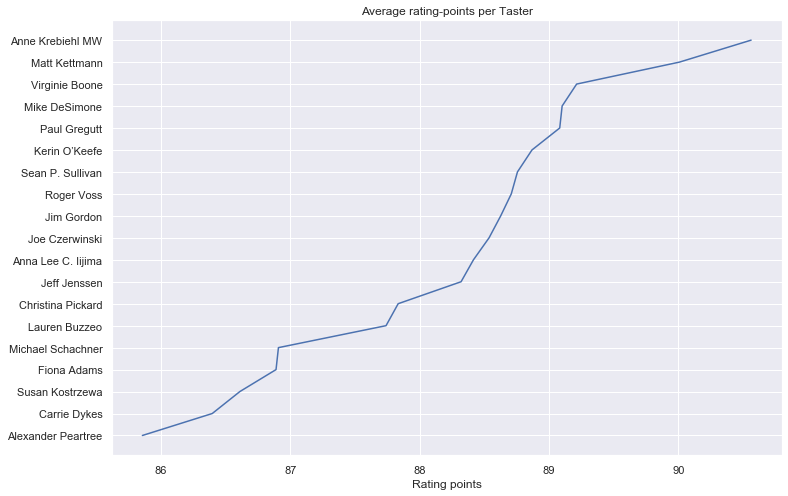

In [47]:
taster = df.groupby('taster_name').points.mean().sort_values()
y = taster.index.to_list()
x = taster.to_list()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)

ax.set_title('Average rating-points per Taster')
ax.set_xlabel('Rating points')

plt.show()
#plt.savefig('Average_Rating_Taster')

### How are the reviews distributed across the varieties of the wines?

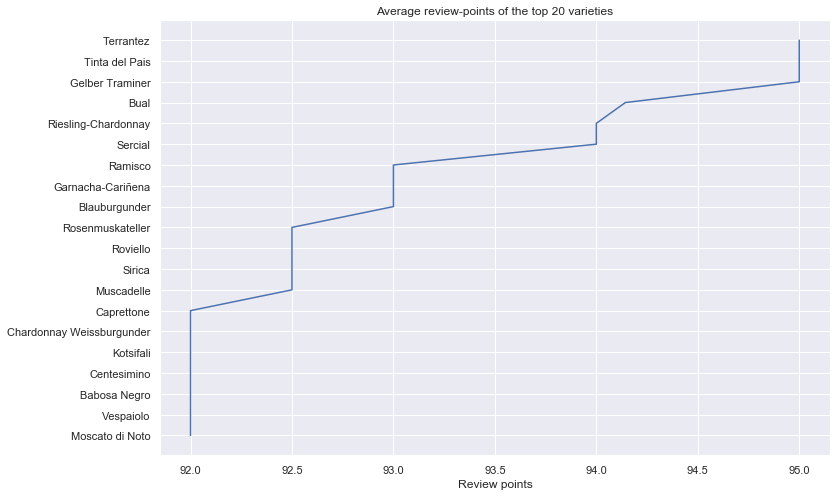

In [48]:
var = df.groupby('variety').points.mean().sort_values()[-20:]
y = var.index.to_list()
x = var.to_list()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)

ax.set_title('Average review-points of the top 20 varieties')
ax.set_xlabel('Review points')

plt.show()
#plt.savefig('Average_rating_top20')

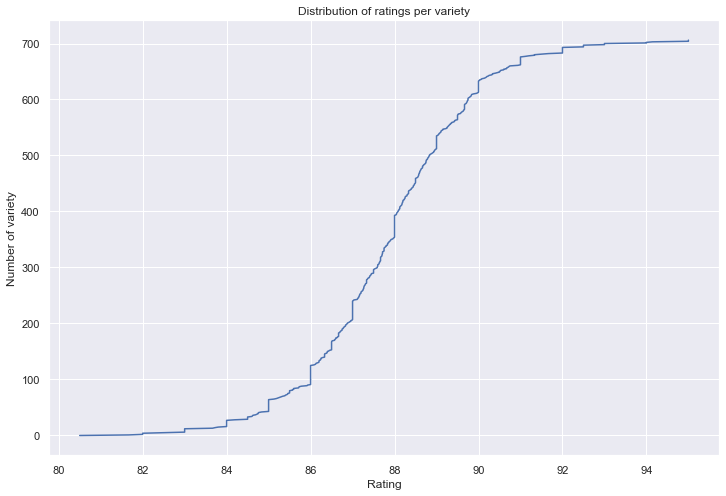

In [49]:
var = df.groupby('variety').points.mean().sort_values()
#y = var.index.to_list()
x = var.to_list()
y = range(0,len(var))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y)

ax.set_title('Distribution of ratings per variety')
ax.set_ylabel('Number of variety')
ax.set_xlabel('Rating')

plt.show()
#plt.savefig('Average_rating_bottom20')

### Understanding the written description

In [50]:
# Taking a look at the describtions
for i in range(1,5):
    print(i)
    print(df['description'].loc[i])

1
This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.
2
Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.
3
Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.
4
Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.


In [51]:
# setting stopwords for now and later use
stop_words = set(stopwords.words("english"))

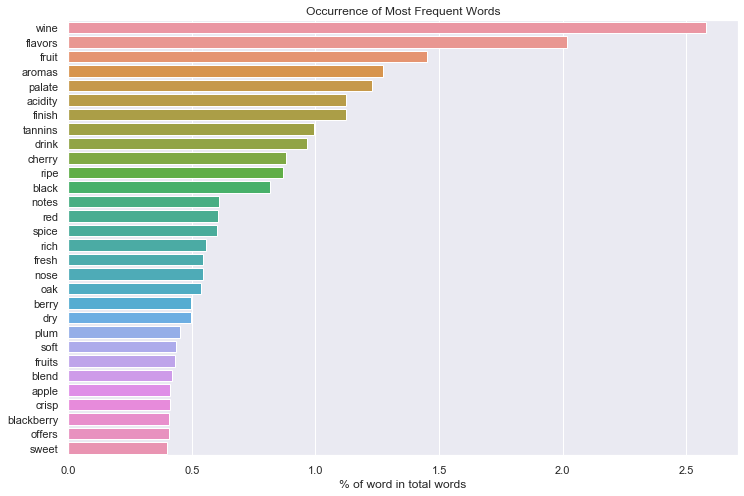

In [52]:
# Detokenizer combines tokenized elements
detokenizer = TreebankWordDetokenizer()

def wrangl_desc(desc):
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stop_words and token.isalpha()]
    return detokenizer.detokenize(desc)

df["wrangl_desc"] = df["description"].apply(wrangl_desc)
word_occurrence = df["wrangl_desc"].str.split(expand=True).stack().value_counts()
total_words = sum(word_occurrence)

# plot most common words 
top_words = word_occurrence[:30]/total_words
ax = sns.barplot(x = top_words.values * 100, y = top_words.index)
ax.set_title("Occurrence of Most Frequent Words")
ax.set_xlabel('% of word in total words')
plt.show()
#plt.savefig('Most_common_words')

The description of a wine is based on the reviewer's ability to grasp the wine's nuances and poignantly communicate those findings. We can see that there are some references to other tastes like horseradish and herbs. There are also descriptions of flavors like acidity and spiciness.  

This leads to the central question of this post: 

**Is it possible to give meaningful recommendations based on the description of a wine?**



To recommend a wine for a customer is a tricky business.  You should know how much a buyer is willing to spend on a purchase. What provinces and varieties a person prefers and how important the wine rating is for the customer.  Those points aside, the domain knowledge of sommeliers and wine salespeople is invaluable to classify wines and recommend based on experience.   

So, for this data science post, I want to investigate if the description of wines in this dataset, combined with provinces and varieties, holds enough information to base recommendations solely on these.



## Data Wrangling

### Checking for duplicates and NaN's
Overall there are 129971 different wines in the dataset with 13 columns.  

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
wrangl_desc              129971 non-null object
dtypes: float64(1), int64(1), object(12)
memory usage: 13.9+ MB


In [54]:
# lets take a look at the NaN provinces
print(df[df['province'].isnull()].shape)
#df[df['province'].isnull()]

(63, 14)


There are 63 NaNs in the province column of the dataset.

In [55]:
# How many duplicated descriptions are in the data set?
df.duplicated('title').sum()

11131

In [56]:
# Find duplicate articles
#df[df.duplicated(['title'])].sort_values(by = 'title')

There are 11131 duplicated descriptions in the the dataset. Let's remove those and the duplicated descriptions and wines.

In [57]:
df.drop_duplicates('title', inplace=True)
df.drop_duplicates('description', inplace=True)
df.dropna(subset=['province', 'variety'], inplace=True)

In [58]:
# generating a long describtion: combining province, variety, and describtion of each wine
df['descr_long'] = df['province'] + ' ' + df['variety'] + ' ' + df['description']

#### Extracting the vintage of a wine from its name to filter the dataset to a specific year

In [59]:
years = df.title.str.extractall('(\d+)')
years.columns = ['year']
years.year = pd.to_numeric(years.year)
# filter vintage
years = years.query('year == 2016')

In [60]:
# check if there are duplicated index values
print(len(years))
print(years.index.get_level_values(level=0).nunique())

3296
3296


In [61]:
years.index = years.index.droplevel(level=1)

In [62]:
df = pd.concat([df, years], axis=1).dropna(subset=["year"])

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3296 entries, 77 to 129907
Data columns (total 16 columns):
country                  3296 non-null object
description              3296 non-null object
designation              2291 non-null object
points                   3296 non-null int64
price                    3165 non-null float64
province                 3296 non-null object
region_1                 2453 non-null object
region_2                 862 non-null object
taster_name              3266 non-null object
taster_twitter_handle    3113 non-null object
title                    3296 non-null object
variety                  3296 non-null object
winery                   3296 non-null object
wrangl_desc              3296 non-null object
descr_long               3296 non-null object
year                     3296 non-null float64
dtypes: float64(2), int64(1), object(13)
memory usage: 437.8+ KB


#### Generating an ID for each wine

In [64]:
wine_id = list([x for x in range(0,len(df))])
df['wine_id'] = wine_id

### Looking at the Occurances of frequent words in the descriptions

In [65]:
# setting stopwords for now and later use
stop_words = set(stopwords.words("english"))

In [66]:
# adding not relevant words to the stop_words set
irrev = {'wine', 'flavors', 'palate', 'drink', 'aromas', 'nose'}
stop_words.update(irrev)

In [67]:
# Function to get a wine description:
def print_wine(wine_id):
    try:
        wine = df[df['wine_id']==wine_id]
        title = wine.iloc[0,10]
        prov = wine.iloc[0,5]
        print("================================================================================================")
        print("Wine: {}".format(title))
        print("Province: {}".format(prov))
        print("Variety: {}".format(wine.iloc[0,11]))
        print("Points: {}".format(wine.iloc[0,3]))
        print("Taster: {}".format(wine.iloc[0,8]))
        print("Description: {}".format(wine.iloc[0,1]))
        print("================================================================================================")
    except:
        print("Please give a valid wine id (integer 0 to {})". format(len(df)))

In [68]:
print_wine(1743)

Wine: La Belle Collection 2016 La Belle Colette Rosé (Côtes de Provence)
Province: Provence
Variety: Rosé
Points: 84
Taster: Roger Voss
Description: A light and fruity wine, this is attractively crisp and with a caramel edge. The wine is bright with touches of orange and lively final acidity. Drink now.


### Transforming the wine descriptions with tf-idf

In [69]:
docs = df.set_index('wine_id').description.astype('U')

In [70]:
r = Rake()
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())   
    r.extract_keywords_from_text(text)
    tokens = list(r.get_word_degrees().keys())
    tokens = [token for token in tokens if token not in stop_words]
    #stemmed = [PorterStemmer().stem(w) for w in tokens]
    lemmed = [WordNetLemmatizer().lemmatize(w) for w in tokens]
    tagged = nltk.pos_tag(lemmed)
    clean_tokens = [token[0] for token in tagged if token[1][0] in ['N', 'J']]
    return clean_tokens

In [71]:
# Fit the docs to the Vectorizer
tf = TfidfVectorizer(tokenizer=tokenize, analyzer='word')
   
X_docs = tf.fit_transform(docs)
labels = list(tf.get_feature_names())

print(X_docs.toarray().shape)

(3296, 3802)


### Creating a matrix with the cosine similarity of the tf-idf values

In [72]:
# get a matrix with the tfidf values
corpus_matrix = X_docs.toarray()

# Take the dot product for the cosine similarity
dot_prod_corpus = corpus_matrix.dot(np.transpose(corpus_matrix))

# Create Dataframe with keywords:
key_words = pd.DataFrame(data=corpus_matrix, columns = labels).transpose()

### Define a function to find top n similar wines for a given wine id

In [73]:
# Function to get a wine description:
def print_wine(wine_id):
    '''
    INPUT
    wine_id - a wine id
    '''
    try:
        wine = df[df['wine_id']==wine_id]
        title = wine.iloc[0,10]
        prov = wine.iloc[0,5]
        print("================================================================================================")
        print("Wine: {}".format(title))
        print("Province: {}".format(prov))
        print("Variety: {}".format(wine.iloc[0,11]))
        print("Points: {}".format(wine.iloc[0,3]))
        print("Taster: {}".format(wine.iloc[0,8]))
        print("Description: {}".format(wine.iloc[0,1]))
        print("================================================================================================")
    except:
        print("Please give a valid wine id (integer 0 to {})". format(len(df)))

In [74]:
def get_wine_names(wine_ids):
    '''
    INPUT
    wine_id - a wine id
    OUTPUT
    wines - a list of wines associated with the wine_ids
    
    '''
    if type(wine_ids)==int:
        wine_ids = [wine_ids]
    wine_lst = [df[df.wine_id==wine]['title'].to_string(index=False,header=False) for wine in wine_ids]    
   
    return wine_lst

In [75]:
def find_similar_wines(wine_id, n=5):
    '''
    INPUT
    wine_id - a wine id
    n - number of similar wines to return
    OUTPUT
    df_sim - a dataframe of the most similar wines by id, name and similarity
    '''
    # find the most similar wine indices 
    key_words_sims = []
    
    similar_idxs = np.argsort(dot_prod_corpus[wine_id])[::-1][1:n+1]
    sims = np.sort(dot_prod_corpus[wine_id])[::-1][1:n+1]
    for idx in similar_idxs:
        wine_keys = key_words[key_words[idx] > 0][idx]
        wine_keys = list(wine_keys.index)[::1]
        key_words_sims.append(wine_keys)

    # pull the movie titles based on the indices
    similar_wines = get_wine_names(similar_idxs)
    
    # dataframe with similarities:
    d = {'wine_id': similar_idxs, 
         'wine': similar_wines,
        'similarity': sims, 
        'key_words': key_words_sims}
    df_sims = pd.DataFrame(d)
 
    return df_sims

df_sims = find_similar_wines(24)
print(get_wine_names(24))
df_sims.head()

[' Zahel 2016 White (Wiener Gemischter Satz)']


,wine_id,wine,similarity,key_words
0,2199,Ebner-Ebenauer 2016 Grüner Veltliner (Niederösterreich),0.309666,"[ample, apple, body, bright, conference, dry, finish, freshness, green, lemon, light, pear, shy,..."
1,2937,Domaine Martin 2016 Les Trois Versants Sur Lie (Muscadet Sèvre et Maine),0.291337,"[acidity, apple, aromatic, citrus, crisp, delicious, full, ripe, zingy]"
2,2807,Stadlmann 2016 Badener Berg Riesling (Niederösterreich),0.263501,"[aromatic, body, brings, citrus, dry, element, force, fresh, full, grapefruit, juiciness, life, ..."
3,2341,Müller-Grossmann 2016 Rosé vom Zweigelt (Niederösterreich),0.251625,"[aroma, citrus, clean, dry, dulls, finish, fresh, light, load, note, redcurrant, reduction, slight]"
4,427,Domaine G. Metz 2016 Melody Riesling (Alsace),0.231798,"[add, apple, body, citrus, delicious, dry, finish, freshness, golden, hint, lemon, lemony, light..."


In [76]:
print_wine(24)
for i in df_sims.wine_id:
    print(i)
    print_wine(i)

Wine: Zahel 2016 White (Wiener Gemischter Satz)
Province: Wiener Gemischter Satz
Variety: White Blend
Points: 90
Taster: Anne Krebiehl MW
Description: Slight reduction still obstructs this wine's nose. The palate, however, is both zingy and rich—spiked with citrus and rounded with ripe, mellow apple fruit. There is verve and life at its core and tone to its medium body. The dry finish is appetizing.
2199
Wine: Ebner-Ebenauer 2016 Grüner Veltliner (Niederösterreich)
Province: Niederösterreich
Variety: Grüner Veltliner
Points: 89
Taster: Anne Krebiehl MW
Description: The nose is rather shy, while the palate brings freshly cut green apple and Conference pear. This is precisely but finely drawn with ample lemon freshness and bright verve. The body is light and dry. Bright, lively lemon on the finish sets the tone.
2937
Wine: Domaine Martin 2016 Les Trois Versants Sur Lie  (Muscadet Sèvre et Maine)
Province: Loire Valley
Variety: Melon
Points: 88
Taster: Roger Voss
Description: Lightly arom

### Create a function for content based recommendations

In [77]:
# Lets asume there are 100 consumers who bought each 5 wines
customer_dict = {}
for cust in range(1,101):
    customer_dict[cust]= list(np.random.randint(len(df), size=5))
customer_dict[2]

[370, 629, 635, 1507, 1265]

In [78]:
def make_content_recs(n=5):
    '''
    INPUT
    n - Number of recommendations by user (default = 10)
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    '''
    # Create dictionary to return with customers and recommendations
    recs = defaultdict(list)
    
    # How many customers for progress bar
    n_users = len(customer_dict)  
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1, 
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    # For each customer
    for cust in customer_dict:
        # Update the progress bar
        cnter+=1 
        bar.update(cnter)
        
        # Wines allready consumed:
        cust_wines = customer_dict[cust]
        
        # find the simmilar wines for each wine_id and concat the data for all articles of the user:
        df_recs = pd.DataFrame()
        for wine_id in customer_dict[cust]:
            df_sim = find_similar_wines(wine_id)
            df_recs = pd.concat([df_recs,df_sim])
            
        #Sorting all wines according the similarity accross all suggestions
        df_recs = df_recs.sort_values('similarity', ascending=False).drop_duplicates('wine_id')
        
        # getting just the ids and filter allready bought wines:
        temp_recs = [wine for wine in df_recs.wine_id if wine not in cust_wines]
        
        # creating the dictionary with just the top n recommendations
        recs[cust]=temp_recs[:n]
        
    bar.finish()
    return recs

In [79]:
recommendations = make_content_recs()

[========================================================================] 100%


In [80]:
# Bought wines from customer 1:
for i in customer_dict[1]:
    print(i)
    print_wine(i)

86
Wine: Viña Cobos 2016 Felino Chardonnay (Mendoza)
Province: Mendoza Province
Variety: Chardonnay
Points: 89
Taster: Michael Schachner
Description: Aromas of apple cider, peach and oak lead to a full palate. Flavors of melon and banana have a nutty quality, while this is stable on the finish, with tropical fruit and honeyed flavors. Drink now.
209
Wine: King Vintners 2016 NEXT Pinot Noir (Oregon)
Province: Oregon
Variety: Pinot Noir
Points: 87
Taster: Paul Gregutt
Description: NEXT is a new label for King Vintners, a new division of King Estate. This blends grapes from southern Oregon and the Willamette Valley, putting a pleasing toasty character around the light red fruit. A streak of burnt coffee suggests that the barrel influence is still being integrated.
2828
Wine: Tongue Dancer 2016 Putnam Vineyard Rosé of Pinot Noir (Sonoma Coast)
Province: California
Variety: Pinot Noir
Points: 90
Taster: Virginie Boone
Description: Proof that that a pink wine can be as serious as it is delic

In [81]:
# Recommendations for customer 1
for i in recommendations[1]:
    print(i)
    print_wine(i)

2276
Wine: Sauvion 2016 Loire Valley  (Muscadet Sèvre et Maine)
Province: Loire Valley
Variety: Melon
Points: 85
Taster: Roger Voss
Description: This is a soft and fruity wine, ripe with apple flavors and cut with a lightly mineral texture. The wine is bright, crisp and fruity, and ready to drink now.
683
Wine: Château Grand Bourgeau 2016  Bordeaux Blanc
Province: Bordeaux
Variety: Sauvignon Blanc
Points: 85
Taster: Roger Voss
Description: This ripe wine is fruity, with both citrus and tropical flavors. Light and bright, with a crisp, tangy texture, it's ready to drink.
1879
Wine: Quinta do Casal Branco 2016 Terra de Lobos Branco White (Tejo)
Province: Tejo
Variety: Portuguese White
Points: 84
Taster: Roger Voss
Description: This young, fruity wine is crisp with acidity and light in texture. The wine is bright and lively, ready to drink for its fruitiness.
914
Wine: Terra Silvestre 2016 Arinto (Tejo)
Province: Tejo
Variety: Arinto
Points: 85
Taster: Roger Voss
Description: Simple and f